## Springboard Data Science Track Capstone Project 2
### Music Genre Classification from Audio Samples
### by Morgan Fry
### Extended Modeling -- LSTM Neural Net

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
%matplotlib inline
import pickle

#import keras
#from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape, Dropout
#from keras.models import Sequential

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_io as tfio

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
else:
    print('no gpu')


In [3]:
#features = pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])
fma_single = pickle.load(open("saved/fma_single.p", "rb"))

In [4]:
fma_single

,split,subset,filepath,genre_top
track_id,,,,
2,training,small,data/fma_large/000/000002.mp3,Hip-Hop
3,training,medium,data/fma_large/000/000003.mp3,Hip-Hop
5,training,small,data/fma_large/000/000005.mp3,Hip-Hop
10,training,small,data/fma_large/000/000010.mp3,Pop
134,training,medium,data/fma_large/000/000134.mp3,Hip-Hop
...,...,...,...,...
155315,training,large,data/fma_large/155/155315.mp3,Rock
155316,training,large,data/fma_large/155/155316.mp3,Rock
155317,training,large,data/fma_large/155/155317.mp3,Rock


For the baseline model we are going to use the 'small' set of 8000 tracks in 8 classes, and train the model on the mfccs of the tracks which we extracted earlier.

In [5]:
#load mfccs
mfcc_df=pickle.load(open("saved/mfcc_small.p","rb"))

In [6]:
mfcc_df.shape

(7997, 23232)

In [7]:
mfcc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,23222,23223,23224,23225,23226,23227,23228,23229,23230,23231
2,-299.542053,-202.513412,-159.976059,-115.456413,-80.415161,-67.523239,-57.689404,-65.464790,-84.703659,-96.179939,...,-5.861199,-4.460218,-6.887738,-7.665272,6.717929,12.769140,11.439809,9.167293,7.916427,5.665779
5,-324.059723,-227.421249,-186.883606,-158.489868,-94.902466,-95.517578,-106.146324,-70.498611,-45.091522,-41.156029,...,-6.403229,-4.675876,5.932048,19.163589,24.138350,12.146925,1.931949,-0.370714,1.137535,-0.625799
10,-71.376122,-32.296730,-29.356266,-38.037708,-44.881695,-45.910717,-31.081173,8.275231,28.077381,6.006516,...,9.814901,0.409050,-6.546686,-4.728213,-2.329597,4.121199,8.337200,8.429386,10.133602,11.033691
140,-561.324280,-523.545837,-449.814423,-342.445557,-306.727356,-308.809631,-307.733276,-317.345245,-362.774811,-419.306946,...,1.818927,3.912658,4.593844,2.139801,-4.394735,-5.267244,-6.697974,-5.783470,-5.886441,-3.706590
141,-464.980743,-371.434326,-330.917175,-342.813904,-362.013550,-368.364441,-361.755188,-358.438049,-365.668640,-375.685730,...,0.601643,-0.995060,0.146230,3.676285,-1.177926,-2.822582,4.884428,3.736303,2.701882,-2.805002


In [8]:
mfcc_df.replace([np.inf, -np.inf], np.nan)

,0,1,2,3,4,5,6,7,8,9,...,23222,23223,23224,23225,23226,23227,23228,23229,23230,23231
2,-299.542053,-202.513412,-159.976059,-115.456413,-80.415161,-67.523239,-57.689404,-65.464790,-84.703659,-96.179939,...,-5.861199,-4.460218,-6.887738,-7.665272,6.717929,12.769140,11.439809,9.167293,7.916427,5.665779
5,-324.059723,-227.421249,-186.883606,-158.489868,-94.902466,-95.517578,-106.146324,-70.498611,-45.091522,-41.156029,...,-6.403229,-4.675876,5.932048,19.163589,24.138350,12.146925,1.931949,-0.370714,1.137535,-0.625799
10,-71.376122,-32.296730,-29.356266,-38.037708,-44.881695,-45.910717,-31.081173,8.275231,28.077381,6.006516,...,9.814901,0.409050,-6.546686,-4.728213,-2.329597,4.121199,8.337200,8.429386,10.133602,11.033691
140,-561.324280,-523.545837,-449.814423,-342.445557,-306.727356,-308.809631,-307.733276,-317.345245,-362.774811,-419.306946,...,1.818927,3.912658,4.593844,2.139801,-4.394735,-5.267244,-6.697974,-5.783470,-5.886441,-3.706590
141,-464.980743,-371.434326,-330.917175,-342.813904,-362.013550,-368.364441,-361.755188,-358.438049,-365.668640,-375.685730,...,0.601643,-0.995060,0.146230,3.676285,-1.177926,-2.822582,4.884428,3.736303,2.701882,-2.805002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154308,-313.429077,-285.330048,-283.423401,-287.088348,-289.263672,-184.150192,-41.746201,-12.892635,-55.076210,-115.045479,...,10.231204,11.211655,0.058539,-11.264427,-6.596434,4.120525,6.856134,5.343898,2.773130,1.698187
154309,-486.301819,-482.713928,-496.109802,-501.279755,-502.606598,-506.784668,-509.464905,-310.994598,-145.997116,-127.237030,...,-3.249464,-10.734337,-11.473764,-8.660153,-7.335606,-11.601185,-16.454685,-15.517137,-11.830728,-11.240954
154413,-155.809250,-137.494919,-114.974205,-140.923645,-162.126450,-160.300812,-160.252792,-164.502640,-163.036118,-166.671722,...,-16.811752,-17.902248,-22.706905,-22.197693,-24.581553,-25.488754,-21.233810,-23.033970,-21.506649,-22.316118
154414,-157.556030,-162.392120,-172.492035,-185.008377,-195.222931,-197.421844,-194.316422,-151.761810,-53.744122,0.694292,...,-14.949778,-13.652007,-14.656978,-12.779702,-15.503021,-17.758909,-18.673512,-14.957970,-11.633366,-14.272188


In [9]:
mfcc_df.fillna(method='ffill',inplace=True)

In [10]:
#use the 8000 track balanced subset for baseline modeling

drop3=pickle.load(open("saved/drop3.p","rb"))
fma_single.drop(drop3, inplace=True)
subset = fma_single.index[fma_single['subset'] == 'small']

In [11]:
fma_small=fma_single.loc[subset]

In [12]:
mfcc_sub=mfcc_df.loc[subset]

In [13]:
#use the built in train/test/validation split in case we want to compare to other models over this dataset
train = fma_small.index[fma_small['split'] == 'training']
val = fma_small.index[fma_small['split'] == 'validation']
test = fma_small.index[fma_small['split'] == 'test']

In [14]:
print(len(train),len(val),len(test))

6310 793 794


In [15]:
#preprocessing single label

#enc=MultiLabelBinarizer()
enc=LabelEncoder()
labels=fma_small['genre_top']
#labels=y_df

# Split in training, validation and testing sets.

#single label
y_train = enc.fit_transform(labels[train])
y_val = enc.transform(labels[val])
y_test = enc.transform(labels[test])
#y_train = track_sub['label']

X_train = mfcc_sub.loc[train].values
X_val = mfcc_sub.loc[val].values
X_test = mfcc_sub.loc[test].values
    
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [16]:
# Standardize features
scaler = StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [30]:
keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Reshape((968,24),input_shape=(X_train.shape[1],)))

model.add(layers.LSTM(units=256, dropout=0.1, return_sequences=True))

model.add(layers.LSTM(units=128, dropout=0.2, return_sequences=False))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))

loss=tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=True)
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 968, 24)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 968, 256)          287744    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 502,408
Trainable params: 502,408
Non-trainable params: 0
__________________________________________________

In [31]:
with tf.device('/GPU:0'):
    history=model.fit(X_train,
              y_train,
              epochs=250,
              batch_size=16,
              validation_data=(X_val, y_val))

Epoch 1/250
395/395 [==============================] - 31s 79ms/step - loss: 2.0390 - accuracy: 0.1731 - val_loss: 2.0325 - val_accuracy: 0.1803
Epoch 2/250
395/395 [==============================] - 30s 76ms/step - loss: 2.0208 - accuracy: 0.1843 - val_loss: 2.0225 - val_accuracy: 0.1955
Epoch 3/250
395/395 [==============================] - 30s 77ms/step - loss: 2.0126 - accuracy: 0.1935 - val_loss: 2.0202 - val_accuracy: 0.2030
Epoch 4/250
395/395 [==============================] - 30s 77ms/step - loss: 2.0068 - accuracy: 0.1968 - val_loss: 2.0163 - val_accuracy: 0.2030
Epoch 5/250
395/395 [==============================] - 30s 77ms/step - loss: 1.9994 - accuracy: 0.2011 - val_loss: 2.0106 - val_accuracy: 0.2182
Epoch 6/250
395/395 [==============================] - 31s 77ms/step - loss: 1.9852 - accuracy: 0.2070 - val_loss: 1.9994 - val_accuracy: 0.2106
Epoch 7/250
395/395 [==============================] - 31s 78ms/step - loss: 1.9677 - accuracy: 0.2209 - val_loss: 1.9782 - val_ac

395/395 [==============================] - 32s 81ms/step - loss: 1.8979 - accuracy: 0.2746 - val_loss: 1.8345 - val_accuracy: 0.2812
Epoch 58/250
395/395 [==============================] - 32s 80ms/step - loss: 1.8376 - accuracy: 0.3008 - val_loss: 1.8074 - val_accuracy: 0.3102
Epoch 59/250
395/395 [==============================] - 32s 81ms/step - loss: 1.8573 - accuracy: 0.2932 - val_loss: 1.9041 - val_accuracy: 0.2812
Epoch 60/250
395/395 [==============================] - 32s 81ms/step - loss: 1.8285 - accuracy: 0.3094 - val_loss: 1.8237 - val_accuracy: 0.3115
Epoch 61/250
395/395 [==============================] - 32s 81ms/step - loss: 1.8062 - accuracy: 0.3185 - val_loss: 1.8358 - val_accuracy: 0.3077
Epoch 62/250
395/395 [==============================] - 32s 80ms/step - loss: 1.7859 - accuracy: 0.3334 - val_loss: 1.7785 - val_accuracy: 0.3480
Epoch 63/250
395/395 [==============================] - 31s 80ms/step - loss: 1.7787 - accuracy: 0.3369 - val_loss: 2.3056 - val_accuracy

395/395 [==============================] - 31s 79ms/step - loss: 1.9227 - accuracy: 0.2428 - val_loss: 1.9470 - val_accuracy: 0.2194
Epoch 114/250
395/395 [==============================] - 31s 79ms/step - loss: 1.9163 - accuracy: 0.2471 - val_loss: 1.9307 - val_accuracy: 0.2446
Epoch 115/250
395/395 [==============================] - 31s 79ms/step - loss: 1.9161 - accuracy: 0.2537 - val_loss: 1.9206 - val_accuracy: 0.2446
Epoch 116/250
395/395 [==============================] - 31s 79ms/step - loss: 1.9084 - accuracy: 0.2594 - val_loss: 1.9297 - val_accuracy: 0.2472
Epoch 117/250
395/395 [==============================] - 31s 79ms/step - loss: 1.9065 - accuracy: 0.2615 - val_loss: 1.9214 - val_accuracy: 0.2497
Epoch 118/250
395/395 [==============================] - 31s 79ms/step - loss: 1.8989 - accuracy: 0.2632 - val_loss: 1.9230 - val_accuracy: 0.2484
Epoch 119/250
395/395 [==============================] - 31s 79ms/step - loss: 1.9062 - accuracy: 0.2545 - val_loss: 1.8977 - val_ac

Epoch 169/250
395/395 [==============================] - 31s 79ms/step - loss: 1.6848 - accuracy: 0.3691 - val_loss: 1.7223 - val_accuracy: 0.3720
Epoch 170/250
395/395 [==============================] - 33s 83ms/step - loss: 1.6809 - accuracy: 0.3718 - val_loss: 1.7372 - val_accuracy: 0.3544
Epoch 171/250
395/395 [==============================] - 33s 83ms/step - loss: 1.6764 - accuracy: 0.3813 - val_loss: 1.6915 - val_accuracy: 0.3770
Epoch 172/250
395/395 [==============================] - 33s 83ms/step - loss: 1.6741 - accuracy: 0.3788 - val_loss: 1.7155 - val_accuracy: 0.3607
Epoch 173/250
395/395 [==============================] - 33s 84ms/step - loss: 1.6717 - accuracy: 0.3811 - val_loss: 1.6799 - val_accuracy: 0.3783
Epoch 174/250
395/395 [==============================] - 33s 85ms/step - loss: 1.6638 - accuracy: 0.3769 - val_loss: 1.6684 - val_accuracy: 0.3960
Epoch 175/250
395/395 [==============================] - 33s 84ms/step - loss: 1.6579 - accuracy: 0.3827 - val_loss: 1

Epoch 225/250
395/395 [==============================] - 35s 90ms/step - loss: 1.5106 - accuracy: 0.4448 - val_loss: 1.6083 - val_accuracy: 0.3997
Epoch 226/250
395/395 [==============================] - 35s 90ms/step - loss: 1.5108 - accuracy: 0.4499 - val_loss: 1.6054 - val_accuracy: 0.4149
Epoch 227/250
395/395 [==============================] - 35s 90ms/step - loss: 1.5036 - accuracy: 0.4458 - val_loss: 1.5777 - val_accuracy: 0.4262
Epoch 228/250
395/395 [==============================] - 35s 90ms/step - loss: 1.5068 - accuracy: 0.4442 - val_loss: 1.6196 - val_accuracy: 0.4061
Epoch 229/250
395/395 [==============================] - 35s 90ms/step - loss: 1.5054 - accuracy: 0.4436 - val_loss: 1.5705 - val_accuracy: 0.4351
Epoch 230/250
395/395 [==============================] - 35s 89ms/step - loss: 1.5000 - accuracy: 0.4528 - val_loss: 1.6424 - val_accuracy: 0.4098
Epoch 231/250
395/395 [==============================] - 35s 90ms/step - loss: 1.5014 - accuracy: 0.4493 - val_loss: 1

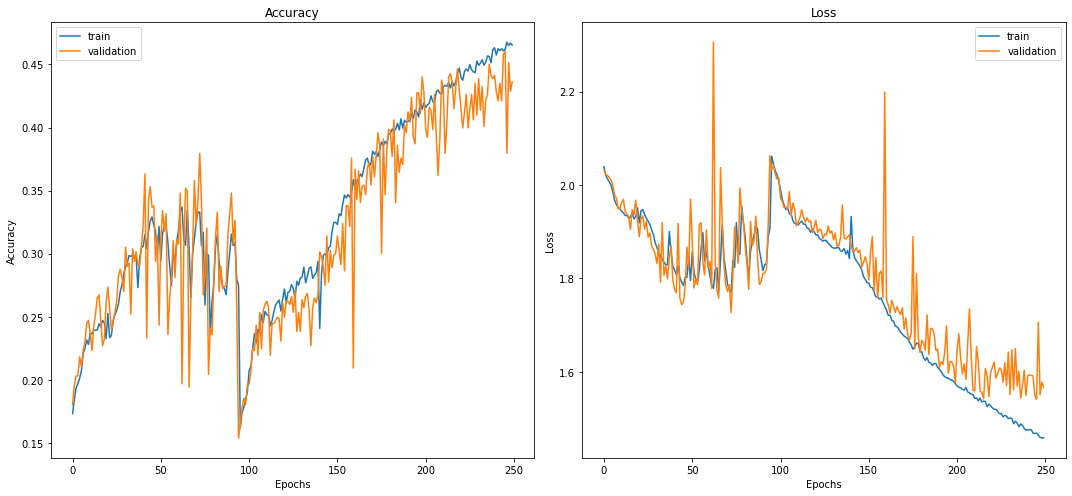

In [32]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
#make clear this is test set
y_pred=model.predict_classes(X_test)
print('Classification Report (test set)')
print(classification_report(y_test,y_pred))

Classification Report (test set)
              precision    recall  f1-score   support

           0       0.39      0.38      0.38        96
           1       0.25      0.18      0.21        98
           2       0.25      0.28      0.27       100
           3       0.49      0.70      0.57       100
           4       0.31      0.24      0.27       100
           5       0.34      0.58      0.43       100
           6       0.21      0.08      0.12       100
           7       0.55      0.47      0.51       100

    accuracy                           0.36       794
   macro avg       0.35      0.36      0.34       794
weighted avg       0.35      0.36      0.34       794



Over the set of:  
* 8 classes
* 1000 samples each class

A baseline model of a fully connected neural net achieves better accuracy over the test set than a Logistic Regression.

| Model | Accuracy(all classes) | Train Time |
| --- | --- | --- |
| CNN | .34 | 15m |
| LSTM | .34 | 90m |


I will extend this model using more complicated neural net architectures as follows:
* Convolutiona Neural Net (CNN)
* Long Short Term Memory (LSTM)
* Combination architecture with both CNN and LSTM layers